In [1]:
import numpy as np
import matplotlib

fsize=8
Fsize=8
# Set global parameters
matplotlib.rcParams['font.size'] = fsize # global
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'
matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['mathtext.default'] ='regular' # makes mathtext mode Arial. note mathtext is used as ticklabel font in log plots

# Set global tick mark parameters
matplotlib.rcParams['xtick.major.width'] = 0.5
matplotlib.rcParams['ytick.major.width'] = 0.5
matplotlib.rcParams['xtick.labelsize']= fsize
matplotlib.rcParams['ytick.labelsize'] = fsize
matplotlib.rcParams['xtick.minor.visible'] = False
matplotlib.rcParams['ytick.minor.visible'] = False
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'


import copy
import sys
sys.path.append('../') # where to find qslam folder

## import qslam modules
import qslamr as qs
from hardware import Node, RealDataGenerator
from qslamdesignparams import GLOBALDICT 
from visualiserisk import Metric, cm2inch
import matplotlib.pyplot as plt

Set sequence: 11
Recommended amplification for real data: 1.0


### Thresholds for Characterising Closeness of Noise Maps (qslam v. Bayes Evaluation )

In [59]:
print "Performance Thresholds"
print "-------------------------------------------------------------------------------------"
var_threshold = 0.05 # \% empirical variance about the Bayes Evaluation deemed close enough

print "Est. residual between qslam and Bayes Evaluation as a % of sample variance: <=", var_threshold * 100
print "Est. residual between qslam and Bayes Evaluation as % of sample st-dev: <=", np.sqrt(var_threshold) * 100

ssim_threshold = 0.5 
# SSIM threshold:
# if 0 == ideal (noiseless), and 1 == bad then this is just halfway.
# Sometimes, ssim metrics >> 1 due to noise + numeric artifacts.

print
print "qslam and Bayes map closeness measured via SSIM score: <=", ssim_threshold

Performance Thresholds
-------------------------------------------------------------------------------------
Est. residual between qslam and Bayes Evaluation as a % of sample variance: <= 2.5
Est. residual between qslam and Bayes Evaluation as % of sample st-dev: <= 15.8113883008

qslam and Bayes map closeness measured via SSIM score: <= 0.5


### Feeding Experimental data 

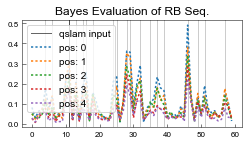


Data Stats:
----------------------------------------------------------------
Total ions: 5
Total seq (primatives only): 60
Total repetitions: 500
Hempel et. al. Bayes Eval: [ 0.2670548   0.30528214  0.22442166  0.18864612  0.15776706]
Empirical Mean: [ 0.32356  0.35446  0.29164  0.26288  0.25502]
Empirical Std: [ 0.38634664  0.40352634  0.37548969  0.34885485  0.33494388]
Empirical Std * Threshold: [ 0.06108677  0.06380312  0.05937013  0.05515879  0.05295928]


In [138]:
empirical_prob, empirical_var, empirical_mean = RealDataGenerator.get_bayes_pbright()
bayesprimitives = RealDataGenerator.bayesprimitives
empirical_map = Node.inverse_born(empirical_prob)

# Plot expt data (post Bayes analysis)

fig = plt.figure(figsize=(cm2inch(10), cm2inch(5)))
ax = fig.add_subplot(111)

ax.set_title('Bayes Evaluation of RB Seq.')


for pick_seq in list(RealDataGenerator.high_grad_seq):
    ax.axvline(x=pick_seq, c='k', lw=1.0, alpha=0.2)

ax.axvline(x=RealDataGenerator.pick_seq_qslam, c='k', lw=1.0, alpha=0.6, label='qslam input')
for n in range(RealDataGenerator.total_ions):
    ax.plot(bayesprimitives[n, :], ':', label='pos: ' + str(n))
        
ax.legend(loc=0)
plt.savefig('source_qslam_on_expt_v2_2.svg', format='svg', dpi=800)
plt.show()

# Print basic stats
print
print "Data Stats:"
print "----------------------------------------------------------------"
print "Total ions:", RealDataGenerator.total_ions
print "Total seq (primatives only):", RealDataGenerator.total_seq
print "Total repetitions:", RealDataGenerator.total_repetitions
print "Hempel et. al. Bayes Eval:", empirical_prob
print "Empirical Mean:", empirical_mean
print "Empirical Std:",  np.sqrt(empirical_var)
print "Empirical Std * Threshold:",  np.sqrt(empirical_var *var_threshold)

### Setting qslam defaults

In [4]:
change_MAX_NUM_ITERATIONS = RealDataGenerator.total_repetitions 
change_MSMTS_PER_NODE = 1
change_SIGMOID_APPROX_ERROR = 10.0**(-6)
change_QUANTISATION_UNCERTY = 10.0**(-4)
change_P_ALPHA = 15 
change_P_BETA = 10 
change_LAMBDA_1 = 0.820
change_LAMBDA_2 = 0.968

GLOBALDICT["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = change_MAX_NUM_ITERATIONS
GLOBALDICT["MODELDESIGN"]["MSMTS_PER_NODE"] = change_MSMTS_PER_NODE
GLOBALDICT["NOISEPARAMS"]["SIGMOID_APPROX_ERROR"]["SIGMA"] = change_SIGMOID_APPROX_ERROR
GLOBALDICT["NOISEPARAMS"]["QUANTISATION_UNCERTY"]["SIGMA"] = change_QUANTISATION_UNCERTY
GLOBALDICT["MODELDESIGN"]["P_ALPHA"] = change_P_ALPHA
GLOBALDICT["MODELDESIGN"]["P_BETA"] = change_P_BETA
GLOBALDICT["MODELDESIGN"]["LAMBDA_1"] = change_LAMBDA_1
GLOBALDICT["MODELDESIGN"]["LAMBDA_2"] = change_LAMBDA_2

### Setting hardware geometry

In [5]:
num_qubits = 5 # number of ions in the trap

In [6]:
change_gridconfig = True

# assume equi-distant linear array
if change_gridconfig is True:
    GLOBALDICT["GRIDDICT"] = {}
    for idx_posy in range(num_qubits):
        if idx_posy < 10 :
            GLOBALDICT["GRIDDICT"]["QUBIT_0" + str(idx_posy)] = (0.0, float(idx_posy))
        if idx_posy >= 10 :
            GLOBALDICT["GRIDDICT"]["QUBIT_" + str(idx_posy)] = (0.0, float(idx_posy))

### Make a test script to run qslam on real data for different regimes

In [7]:
def real_data_trial(SAMPLE_GLOBAL_MODEL,
                   measurements_controls_=None,
                   autocontrol_="ON",
                   var_thres_=1.0):

    '''Return map reconstruction and state variables from one trial of an algorithm on real data.'''

    qslamobj = qs.ParticleFilter(SAMPLE_GLOBAL_MODEL)
    qslamobj.QubitGrid.engineeredtruemap = None
    qslamobj.QubitGrid.real_data = True


    qslamobj.qslamr(measurements_controls=measurements_controls_,
                         autocontrol=autocontrol_,
                         max_num_iterations=SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["MAX_NUM_ITERATIONS"],
                         var_thres=var_thres_)

    posterior_map = qslamobj.QubitGrid.get_all_nodes(["f_state"])
    posterior_corrs = qslamobj.QubitGrid.get_all_nodes(["r_state"])
    controlpath = qslamobj.QubitGrid.control_sequence

    return posterior_map, posterior_corrs, controlpath

In [8]:
msmt_per_node_scan = [1, 2, 5, 6, 10, 12, 15, 20, 25]

def get_msmt_scan(msmt_per_node, total_budget):
    max_iter = int(total_budget / msmt_per_node) 
    
    if max_iter <= 40:
        regimes = [1] + range(0, max_iter + 1, 2 )[1:]
        return regimes
    
    if max_iter <= 100:
        regimes = [1] + range(0, max_iter + 1, 5 )[1:]
        return regimes
    
    if max_iter > 100:
        step_size = 25
        if max_iter >= 500:
            step_size = 50
            
    regimes = [1] + range(0, 100 + 1, 5)[1:] + range(100, max_iter + 1, step_size )[1:]
    return regimes


Using 1 shot per iteration...


/home/riddhisw/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


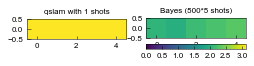

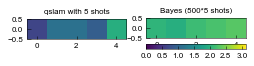

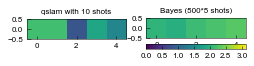

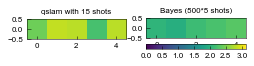

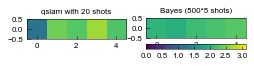

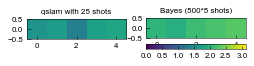

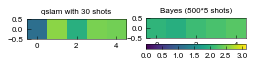

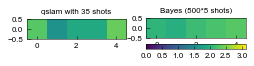

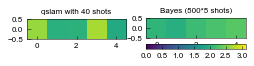

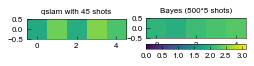

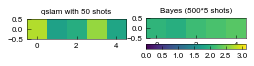

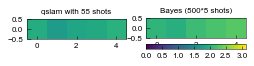

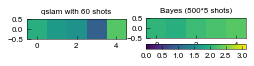

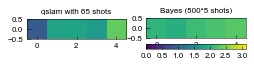

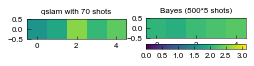

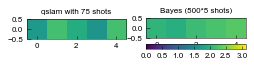

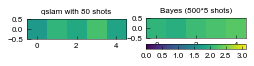

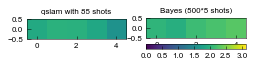

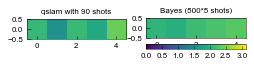

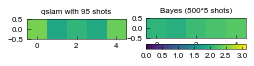

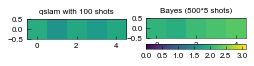

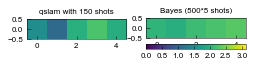

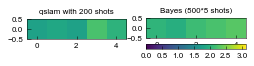

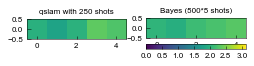

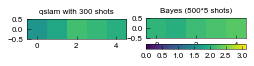

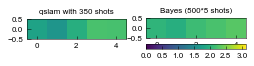

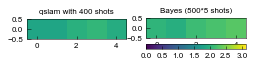

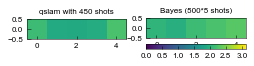

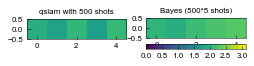

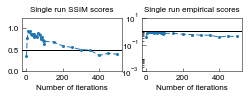


Using 2 shot per iteration...


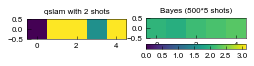

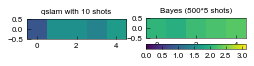

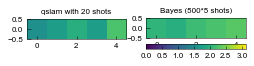

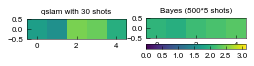

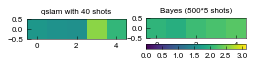

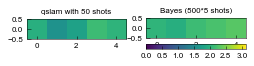

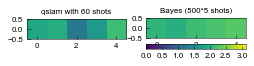

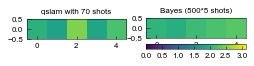

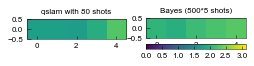

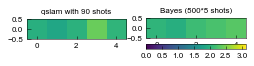

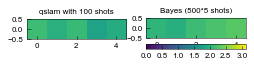

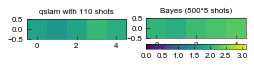

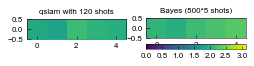

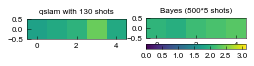

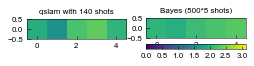

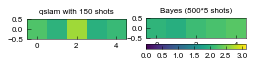

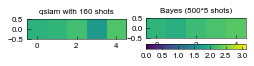

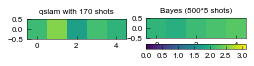

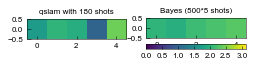

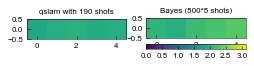

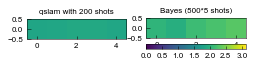

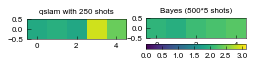

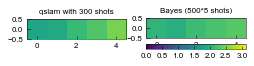

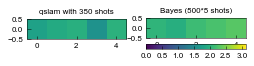

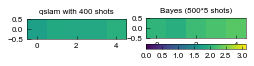

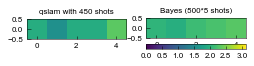

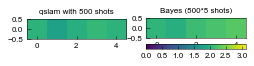

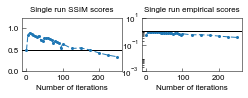


Using 5 shot per iteration...


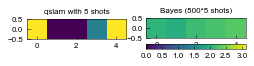

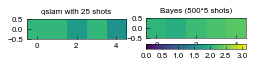

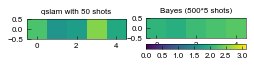

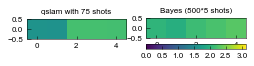

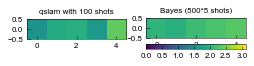

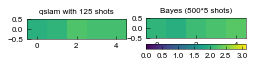

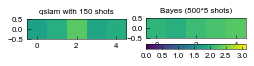

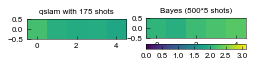

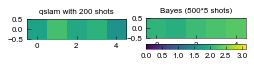

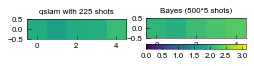

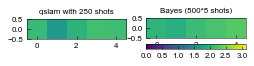

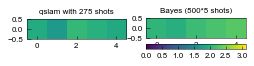

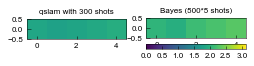

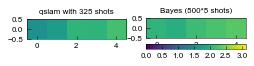

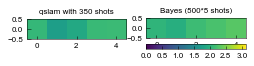

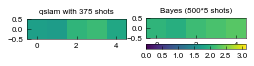

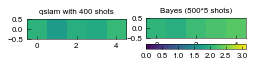

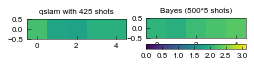

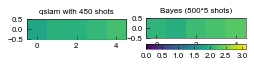

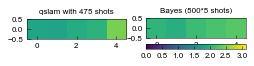

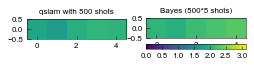

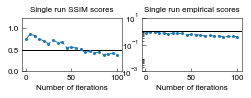


Using 6 shot per iteration...


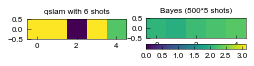

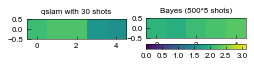

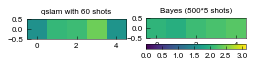

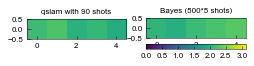

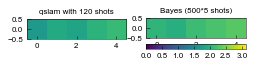

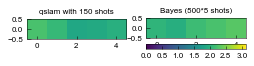

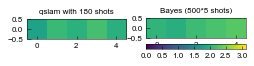

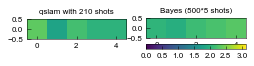

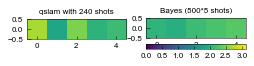

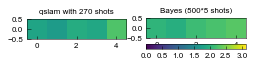

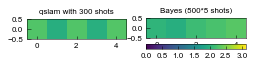

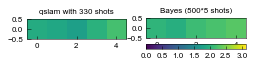

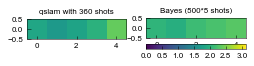

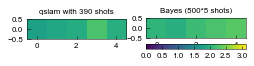

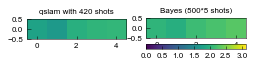

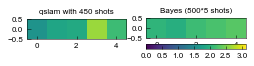

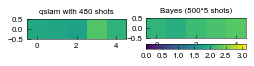

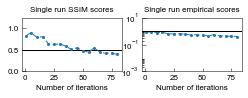


Using 10 shot per iteration...


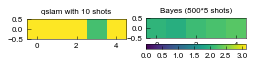

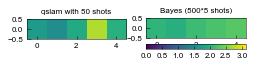

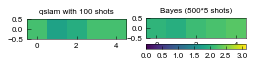

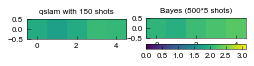

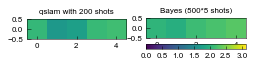

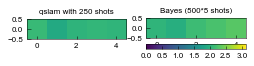

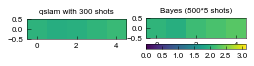

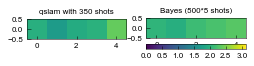

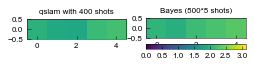

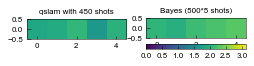

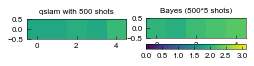

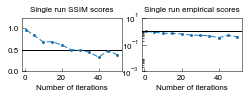


Using 12 shot per iteration...


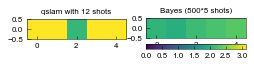

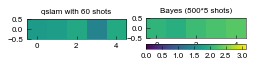

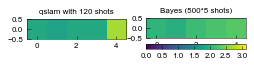

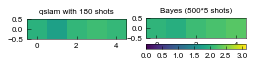

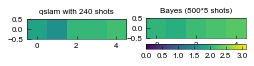

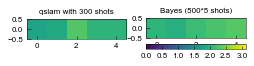

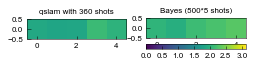

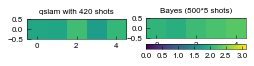

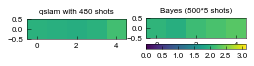

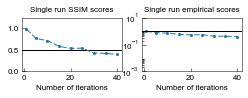


Using 15 shot per iteration...


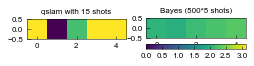

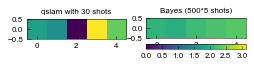

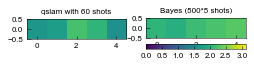

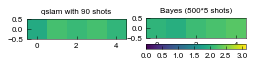

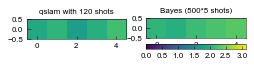

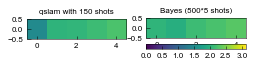

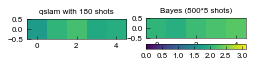

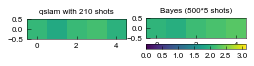

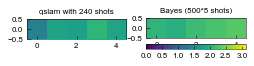

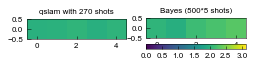

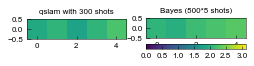

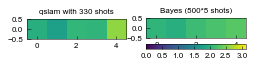

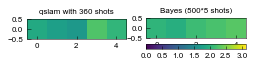

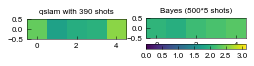

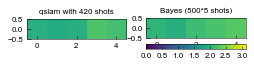

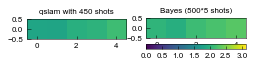

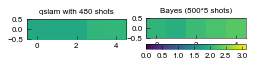

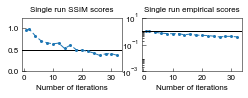


Using 20 shot per iteration...


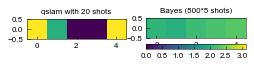

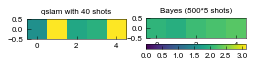

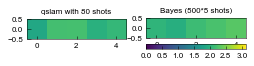

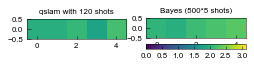

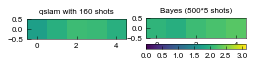

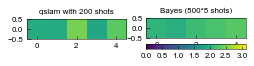

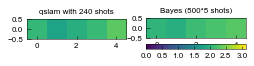

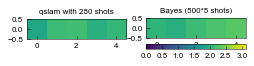

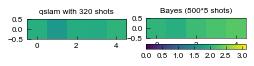

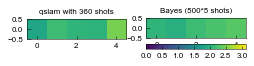

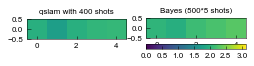

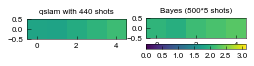

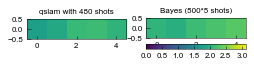

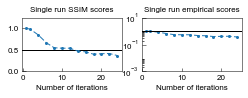


Using 25 shot per iteration...


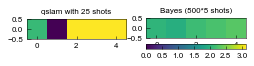

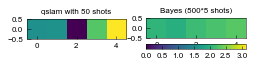

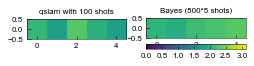

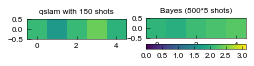

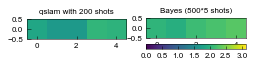

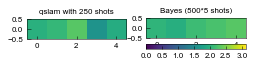

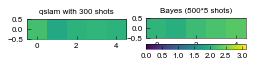

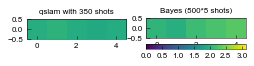

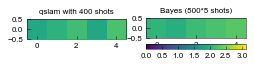

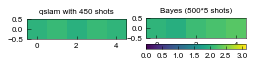

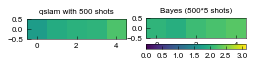

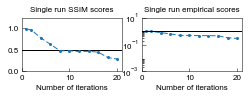

In [9]:
num_of_runs = 50 # number of runs to calculated expected risk metric (not for inference)

SAMPLE_GLOBAL_MODEL = copy.deepcopy(GLOBALDICT)

meta_ssim_pairs = []
meta_empr_pairs = []

for idx_msmtpernode in range(len(msmt_per_node_scan)):
    
    print
    print "Using %s shot per iteration..." %(msmt_per_node_scan[idx_msmtpernode])

    SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["MSMTS_PER_NODE"] = msmt_per_node_scan[idx_msmtpernode]
    
    max_iterations_regime = get_msmt_scan(msmt_per_node_scan[idx_msmtpernode], RealDataGenerator.total_repetitions)
    
    list_of_scores = []
    list_of_empirical_scores = []
    
    for idx_msmt_iter in range(len(max_iterations_regime)):
    
        SAMPLE_GLOBAL_MODEL["MODELDESIGN"]["MAX_NUM_ITERATIONS"] = max_iterations_regime[idx_msmt_iter]
        
        ssim_array = np.zeros(num_of_runs)
        empr_array = np.zeros(num_of_runs)
        
        for idx_run in range(num_of_runs):
            
            posterior_map = real_data_trial(SAMPLE_GLOBAL_MODEL)[0]
            ssim_array[idx_run] = Metric.score_ssim(posterior_map, empirical_map, Cone=0.01, Ctwo=0.01)
            empr_array[idx_run] = np.linalg.norm((posterior_map - empirical_map)**2 / var_threshold*empirical_var)

        # Calculate expected risk
        list_of_scores.append(np.mean(ssim_array))
        list_of_empirical_scores.append(np.mean(ssim_array))

        # Plot the last single run example
        shots = max_iterations_regime[idx_msmt_iter] * msmt_per_node_scan[idx_msmtpernode]
        fig = plt.figure( figsize=(cm2inch(10), cm2inch(2)))
        ax = fig.add_subplot(1, 2, 1)
        ax.set_title('qslam with %s shots' %(shots), fontsize=fsize)
        iax = ax.imshow(posterior_map[np.newaxis], origin='lower', vmin=0, vmax=np.pi)
        ax = fig.add_subplot(1, 2, 2)
        ax.set_title('Bayes (500*5 shots)', fontsize=fsize)
        iax2 = ax.imshow(empirical_map[np.newaxis], origin='lower', vmin=0, vmax=np.pi)
        plt.colorbar(iax, orientation='horizontal')
        plt.show()

    fig = plt.figure( figsize=(cm2inch(10), cm2inch(2.5)))
    
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('Single run SSIM scores',fontsize=fsize)
    ax.axhline(y=ssim_threshold, c='k', lw=1.0, label='Perf. Threshold')
    ax.plot(max_iterations_regime, list_of_scores, 'o--', lw=1.0, ms=2.)
    ax.set_ylim([0, 1.25])
    ax.set_xlabel('Number of iterations',fontsize=fsize)
    # ax.set_ylabel('Empirical SSIM score')
    
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('Single run empirical scores', fontsize=fsize)
    ax.plot(max_iterations_regime, list_of_empirical_scores, 'o--', lw=1.0, ms=2.)
    ax.axhline(y=1.0, c='k', lw=1.0, label='Perf. Threshold')
    ax.set_yscale('log')
    ax.set_ylim([10**-3, 10**1])
    ax.set_xlabel('Number of iterations',fontsize=fsize)
    # ax.set_ylabel('Empirical variance deviation ')
    plt.show()
    
    meta_ssim_pairs.append(zip(max_iterations_regime, list_of_scores))
    meta_empr_pairs.append(zip(max_iterations_regime, list_of_empirical_scores))
    
    np.savez('qslam_perf_real_data_2', msmt_per_node_scan=msmt_per_node_scan, meta_ssim_pairs=meta_ssim_pairs, meta_empr_pairs=meta_empr_pairs)

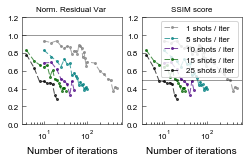

In [136]:
colours = [ 'grey', 'lightblue', 'teal', 'slateblue', 'indigo', 'darkslateblue',  'darkgreen', 'navy', 'k']

fig = plt.figure( figsize=(cm2inch(10), cm2inch(5)))


ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
for idx_msmt_per_node in range(len(msmt_per_node_scan))[::2]:
    

    msmt_per_node = msmt_per_node_scan[idx_msmt_per_node]
    
    # Loop later
    # Plot 1 ----------------------------------------------------------------------------------------
    x, y = zip(*meta_empr_pairs[idx_msmt_per_node])
    ax1.plot(x[2:], y[2:], 'o--', 
            c= colours[idx_msmt_per_node], 
            lw=1.0, alpha=0.7, ms=2., 
            label = str(msmt_per_node) + ' shots / iter')

    
    # Plot 2 ----------------------------------------------------------------------------------------
    x, y = zip(*meta_ssim_pairs[idx_msmt_per_node])
    ax2.plot(x[2:], y[2:], 'o--', 
            c= colours[idx_msmt_per_node], 
            lw=1.0, alpha=0.7, ms=2., 
            label = str(msmt_per_node) + ' shots / iter')
    

ax1.axhline(y=1.0, 
           c='k', ls='-', alpha=0.4, lw=1.)
ax2.axhline(y=ssim_threshold, 
            c='k', ls='-', alpha=0.4, lw=1.)



for ax in [ax1, ax2]:
    
    ax.set_ylim([0., 1.2])
    ax.set_xscale('log')
    ax.set_xlabel('Number of iterations', fontsize=10)

ax1.set_title('Norm. Residual Var ', fontsize=fsize)
ax2.set_title('SSIM score', fontsize=fsize)
ax2.legend(loc=0, fontsize=fsize)

plt.savefig('qslam_on_expt_v2_2.svg', format='svg', dpi=800)
plt.show()